# Report of https://arnaud-legrand.shinyapps.io/design_of_experiments/?user_o255

The goal is to find which values maximize the `y` value from 11 different variables.

## Variables dependency

The first thing I attempted to do is trying to know if variables were independant from eachother. There is always a noise on the value we get, and we can check this by submitting multiple times th same experiment.

For each pair of variable (55 possibilities), let's do three measurements:
- One is only having "1" for the first variable of the pair
- Second is only having "1" for the second one
- Third is having "1" for both and seeing if it is just the sum of the two transformations

In [ ]:
# Print all triplets useful for the calculations
for i in range(11):
    for j in range(i+1, 11):
        # First has one
        print("0,"*i, "1", ",0"*(10-i), sep="")
        # Second has one
        print("0,"*j, "1", ",0"*(10-j), sep="")
        # Both have one
        print("0,"*i, "1", ",0"*(j-i-1), ",1", ",0"*(10-j), sep="")

Now let's check if the transformations are just the sum of the two individuals, which would mean it is likely independant.

In [2]:
max_diff = 0
with open('squares.txt', 'r') as f:
    base_value = None
    for i, l in enumerate(f):
        if not base_value:
            base_value = float(l.split(',')[-1])
            print(f"base_value : {base_value}")
        elif i%3==1:
            first_val = float(l.split(',')[-1])
        elif i%3==2:
            second_val = float(l.split(',')[-1])
        elif i%3==0:
            third_val = float(l.split(',')[-1])
            expected_val = first_val + second_val - base_value
            diff = third_val-expected_val
            if abs(diff)>0.01:
                print(f"Expected {expected_val}, got {third_val} (diff {diff})")
                print(l)
            max_diff = max(abs(diff), max_diff)
print(f"Max diff : {max_diff}")

base_value : 1.01253954454545
Expected 2.01598075043869, got 1.71478938499032 (diff -0.3011913654483702)
0,0,0,1,0,0,1,0,0,0,0,1.71478938499032

Expected 0.023895439375812177, got 0.0114804199592722 (diff -0.012415019416539977)
0,0,0,1,0,0,0,0,1,0,0,0.0114804199592722

Expected -0.9764530904630219, got -0.987702577484058 (diff -0.01124948702103612)
0,0,0,0,0,0,1,0,1,0,0,-0.987702577484058

Max diff : 0.3011913654483702


The maximum delta I had between the expected values from the sum of the two variables and the real value is very low in general, expect for three cases. While two of them could be due to noise, the first one is really high. Let's investigate further.

We are going to try a few values for each variables and try to find how they relate.

In [4]:
# Test relation between var. 4 and 7
# Print everything useful for the calculations
for i in range(5):
    for j in range(5):
        # First has one
        print("0,"*3, i/4, ",0"*2, ",", j/4, ",0"*4, sep="")

0,0,0,0.0,0,0,0.0,0,0,0,0
0,0,0,0.0,0,0,0.25,0,0,0,0
0,0,0,0.0,0,0,0.5,0,0,0,0
0,0,0,0.0,0,0,0.75,0,0,0,0
0,0,0,0.0,0,0,1.0,0,0,0,0
0,0,0,0.25,0,0,0.0,0,0,0,0
0,0,0,0.25,0,0,0.25,0,0,0,0
0,0,0,0.25,0,0,0.5,0,0,0,0
0,0,0,0.25,0,0,0.75,0,0,0,0
0,0,0,0.25,0,0,1.0,0,0,0,0
0,0,0,0.5,0,0,0.0,0,0,0,0
0,0,0,0.5,0,0,0.25,0,0,0,0
0,0,0,0.5,0,0,0.5,0,0,0,0
0,0,0,0.5,0,0,0.75,0,0,0,0
0,0,0,0.5,0,0,1.0,0,0,0,0
0,0,0,0.75,0,0,0.0,0,0,0,0
0,0,0,0.75,0,0,0.25,0,0,0,0
0,0,0,0.75,0,0,0.5,0,0,0,0
0,0,0,0.75,0,0,0.75,0,0,0,0
0,0,0,0.75,0,0,1.0,0,0,0,0
0,0,0,1.0,0,0,0.0,0,0,0,0
0,0,0,1.0,0,0,0.25,0,0,0,0
0,0,0,1.0,0,0,0.5,0,0,0,0
0,0,0,1.0,0,0,0.75,0,0,0,0
0,0,0,1.0,0,0,1.0,0,0,0,0


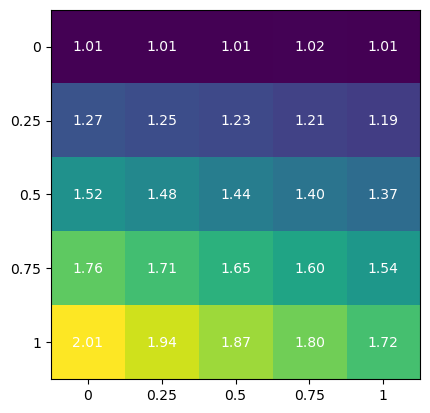

In [40]:
res_array = []
with open('var4and7', 'r') as f:
    n = 0
    for l in f:
        line = l.split(',')
        var4, var7, val = map(float, line)
        if n%5==0:
            res_array.append([])
        n += 1
        res_array[-1].append(val)
    
# Plot based from https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
im = ax.imshow(res_array)
ax.set_xticks([i for i in range(5)], labels=[0, 0.25, 0.5, .75, 1])
ax.set_yticks([i for i in range(5)], labels=[0, 0.25, 0.5, .75, 1])

# Loop over data dimensions and create text annotations.
for i in range(5):
    for j in range(5):
        text = ax.text(j, i, f"{res_array[i][j]:.2f}",
                       ha="center", va="center", color="w")

plt.show()

It looks like maximizing $x_4$ (here on the y axis) and minimizing $x_7$ (the x axis) is the best. So from now we will consider that it is best to keep $x_7$ at $0$.

## Finding the value for each variable independently

Since we consider all variables to be independent (variable $x_7$ is kept at 0), we can now try to only change only variable at a time and find it's best value on the range $(0,1)$.

I think the best approach would be to use the "Gaussian Process Surrogate Models" approach to always find the most interesting point to check. Sadly I haven't taken the time to install any tool for this so for the moment I will plot different points, then try to compute more points where it seems interesting.

In [79]:
def gen_exp_range(var, min, max):
    """generate 20 exp, from min to max, for targeted variable"""
    for i in range(20):
        print("0,"*(var-1), min+(max-min)*i/19, ",0"*(11-var), sep="")

gen_exp_range(1, 0.7, .8)

0.7,0,0,0,0,0,0,0,0,0,0
0.7052631578947368,0,0,0,0,0,0,0,0,0,0
0.7105263157894737,0,0,0,0,0,0,0,0,0,0
0.7157894736842105,0,0,0,0,0,0,0,0,0,0
0.7210526315789474,0,0,0,0,0,0,0,0,0,0
0.7263157894736841,0,0,0,0,0,0,0,0,0,0
0.731578947368421,0,0,0,0,0,0,0,0,0,0
0.7368421052631579,0,0,0,0,0,0,0,0,0,0
0.7421052631578947,0,0,0,0,0,0,0,0,0,0
0.7473684210526316,0,0,0,0,0,0,0,0,0,0
0.7526315789473684,0,0,0,0,0,0,0,0,0,0
0.7578947368421053,0,0,0,0,0,0,0,0,0,0
0.7631578947368421,0,0,0,0,0,0,0,0,0,0
0.768421052631579,0,0,0,0,0,0,0,0,0,0
0.7736842105263158,0,0,0,0,0,0,0,0,0,0
0.7789473684210526,0,0,0,0,0,0,0,0,0,0
0.7842105263157895,0,0,0,0,0,0,0,0,0,0
0.7894736842105263,0,0,0,0,0,0,0,0,0,0
0.7947368421052632,0,0,0,0,0,0,0,0,0,0
0.8,0,0,0,0,0,0,0,0,0,0


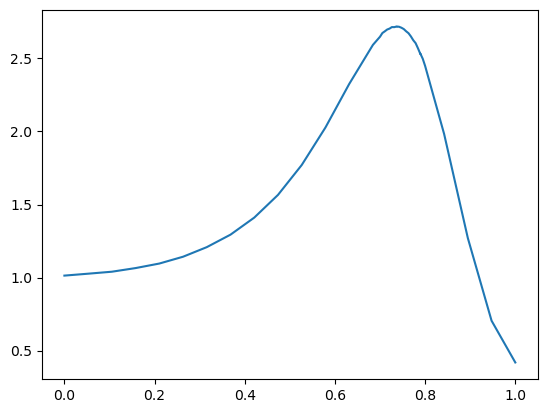

Max value found for x1 : (0.736842105263158, 2.71860997027224)


In [82]:
def plot_var(var):
    with open('vars/var'+str(var), 'r') as f:
        vals = []
        for l in f:
            line = list(map(float, l.split(',')))
            vals.append((line[var-1], line[-1]))
            vals = sorted(vals)
            x = [e[0] for e in vals]
            y = [e[1] for e in vals]
    
    fig, ax = plt.subplots()
    ax.plot(x, y)
    plt.show()
    print(f"Max value found for x{var} :", max(vals, key=lambda x: x[1]))

plot_var(1)

This is an example for $x_1$, for which I started with 20 points, then computed more on the range (0.7, 0.8).
We also print the maximum value found.

So, we will keep $x_1=0.736842$ for the final answer.

We can do the same process for the other variables.

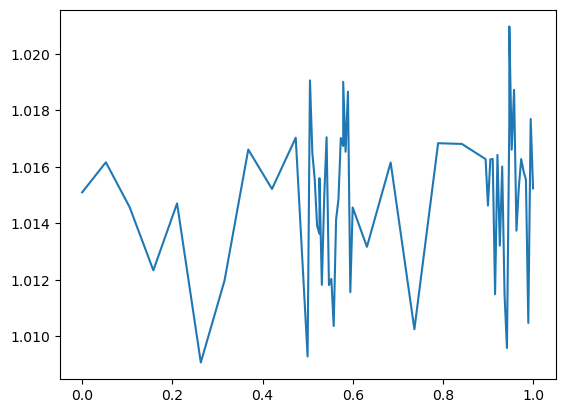

Max value found for x2 : (0.947368421052632, 1.02097609230603)


In [77]:
plot_var(2)

As we can see, it is much harder to know the best value for some variables because of the noise, or maybe the function behing too much chaotic. A way to get around it is sampling multiple times the same values and taking the average we get.

For the moment, I will simply plot a lot of points and find the maximum for each variable out of 100 tries.

The best value for each variable are the following (some are likely chosen because of noise/chaos behaviour):
$(0.736842, 0.947368, 1, 1, 0.727272, 0.979798, 0, 0.343434, 0, 0.111111, 0.919192)$

The final result we get from this vector is: $3.72201066203119$

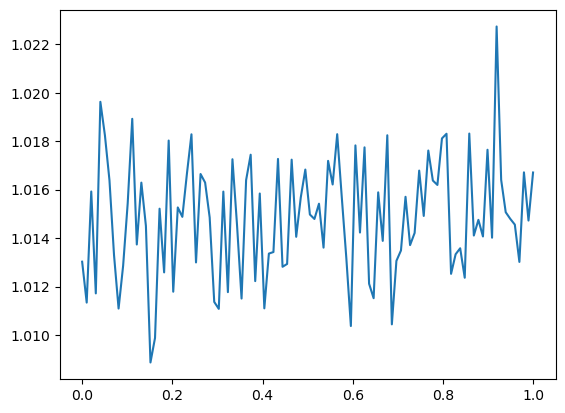

Max value found for x11 : (0.919191919191919, 1.02273820190335)


In [90]:
plot_var(11)